In [1]:
# https://dingwb.github.io/PyComplexHeatmap/build/html/notebooks/composite_heatmaps.html
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("notebook", rc={"lines.linewidth": 3})
##################################################
plt.style.use('tableau-colorblind10')
##################################################
import numpy as np

cate = "primaryNivo"
ano = ".positive."

df_cate = pd.read_csv(f"{cate}{ano}connectivity.txt",index_col=0)

df_cl = pd.read_csv("../braun_data_log2_or_not/braun_data_S1_Clinical_and_Immune_Data.csv")

df_merge = pd.merge(df_cate.T.reset_index(),df_cl,how='left', left_on="index", right_on="RNA_ID" )

def replace_outlier(pd_series):
    l = pd_series.to_numpy()
    low = pd_series.quantile(0.02)
    up = pd_series.quantile(0.98)
    l = [e if (low < e) else low for e in l]
    l = [e if (up > e) else up for e in l]
    return l
    
def next_replace_out(pdf):
    gene_tar = pdf.columns.to_list()[1:-121]
    for i in gene_tar:
        pdf[i] = replace_outlier(pdf[i])
    return pdf

pdf = next_replace_out(df_merge.copy())
pdf.columns = ["samples"] + pdf.columns.tolist()[1:]
pdf.set_index("samples",inplace=True)

pdf.fillna(0,inplace=True)

/tmp/ipykernel_1296429/3853288686.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pdf.fillna(0,inplace=True)


21


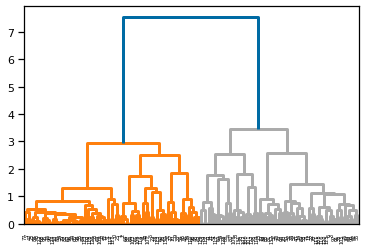

In [2]:
#ano=""
resos = pd.read_csv(f"{cate}{ano}_os_significant_nodes_by_connectivity.txt")
respfs = pd.read_csv(f"{cate}{ano}_pfs_significant_nodes_by_connectivity.txt")
#significant_gene = set(resos[resos["ttest"]<0.05]["covariate"].tolist()).union(respfs[respfs["ttest"]<0.05]["covariate"].tolist())#


####### 1st choice
significant_gene_inter = set(resos[resos["p"]<0.01]["covariate"].tolist()).intersection(respfs[respfs["p"]<0.01]["covariate"].tolist())
#significant_gene_inter = set(resos[resos["p"]<0.01]["covariate"].tolist()).union(respfs[respfs["p"]<0.01]["covariate"].tolist())

print(len(significant_gene_inter))

tar = pdf[list(significant_gene_inter)]
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy import stats

linkage_data = linkage(pdist(stats.zscore(tar), 'cosine'), method='ward', metric='euclidean')
dn = dendrogram(linkage_data)
plt.show() 

In [3]:
from scipy.cluster.hierarchy import fcluster

fl = fcluster(linkage_data,2,criterion='maxclust')
print(fl)
#pdf["cres"] = [2 if i != 3 else i for i in fl ]

def swapPositions(lis):
    newlis = []
    for i in lis:
        if i == 1:
            newlis.append(2)
        if i == 2:
            newlis.append(1)
    return newlis
    
pdf["cres"] =fl
#pdf["cres"] =swapPositions(fl)
set(pdf["cres"])

[1 1 1 2 2 1 2 1 2 1 1 2 2 2 2 1 1 1 1 2 2 2 2 1 1 1 1 1 2 1 2 1 2 2 1 1 2
 1 1 2 2 1 2 1 1 1 1 1 1 2 2 2 2 1 2 2 1 2 2 2 1 1 1 1 1 1 1 1 1 2 2 2 1 2
 1 2 2 1 2 1 2 2 1 1 1 2 2 1 1 2 1 2 1 2 1 1 1 2 1 2 2 2 2 1 1 2 2 1 2 1 1
 2 2 1 1 1 2 2 1 2 2 1 1 1 1 2 1 2 2 2 1 2 2]


/tmp/ipykernel_1296429/1619751478.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pdf["cres"] =fl


{1, 2}

(133, 20667)


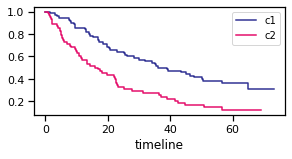

In [4]:
from lifelines import KaplanMeierFitter
from lifelines.datasets import load_waltons
from sksurv.compare import compare_survival
import numpy as np

pdf1 = pdf.copy()
print(pdf1.shape)
y = pdf[["OS_CNSR","OS"]].values
y = np.array([ (i[0],i[1]) for i in y],dtype="bool,f")

ix = pdf1['cres'] == 1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 2))

######################
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('default')
#####################
kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(pdf1.loc[ix]["OS"], pdf1.loc[ix]["OS_CNSR"], label='c1').plot_survival_function(ax=ax,ci_show =False,color='#2e3092')

kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(pdf1.loc[~ix]["OS"], pdf1.loc[~ix]["OS_CNSR"], label='c2').plot_survival_function(ax=ax,ci_show =False,color='#e40c69')
plt.show()

In [5]:
"""
selected_mutation = ['Amplification_1q32.1', 'Amplification_8p11.21', 'Deletion_5q14.1',
       'Deletion_9p21.3', 'Deletion_9q34.3', 'Deletion_10q23.31',
       'Deletion_10q26.3', 'Deletion_11q12.3', 'Deletion_11q23.1',
       'Deletion_12q24.33', 'PBRM1_y', 'SETD2_y']
"""
all_mutation = pdf.columns[-72:-6].tolist()
selected_mutation = []

In [6]:
import numpy as np
from scipy.stats import fisher_exact
dic_mutation = {}
for  i in all_mutation:#pdf.columns[-72:-6].tolist():
    #print(set(pdf[pdf["cres"]==1][i].tolist()),pdf[pdf["cres"]==1][i].tolist().count(0))
    c1o = pdf[pdf["cres"]==1][i].tolist().count("MUT") + pdf[pdf["cres"]==1][i].tolist().count("WT")
    c1 = pdf[pdf["cres"]==1][i].tolist().count("MUT")
    c2o = pdf[pdf["cres"]==2][i].tolist().count("MUT") + pdf[pdf["cres"]==2][i].tolist().count("WT")
    c2 = pdf[pdf["cres"]==2][i].tolist().count("MUT")
    """
    c3o = pdf[pdf["cres"]==3][i].tolist().count("MUT") + pdf[pdf["cres"]==3][i].tolist().count("WT")
    c3 = pdf[pdf["cres"]==3][i].tolist().count("MUT")
    c4o = pdf[pdf["cres"]==4][i].tolist().count("MUT") + pdf[pdf["cres"]==4][i].tolist().count("WT")
    c4 = pdf[pdf["cres"]==4][i].tolist().count("MUT")
    table = np.array([[c1o, c2o], [c1, c2]])
    res = fisher_exact(table, alternative='two-sided')
    #print(table,i, res.pvalue   )
    dic_mutation[i] =  [c1o, c2o,c3o,c4o, c1, c2,c3,c4,res.pvalue]"""
    table = np.array([[c1o, c2o], [c1, c2]])
    res = fisher_exact(table, alternative='two-sided')
    if res.pvalue < 0.4:
        selected_mutation.append(i)
        dic_mutation[i] =  [c1o, c2o, c1, c2,res.pvalue]

In [7]:
data_complex = pdf[pdf.columns[-72:-6].tolist()].stack().reset_index().copy() #["cres","Benefit"]
data_complex = data_complex.replace(0,"None")
data_complex.columns=['SampleID','Genes','Variants']
data_complex= data_complex[data_complex["Genes"].isin(selected_mutation)].copy()

unique_variants=[]
for var in data_complex.Variants.dropna().unique():
    for v1 in var.split(';'):
        v1=v1.strip()
        if v1=='':
            continue
        if v1 not in unique_variants:
            unique_variants.append(v1)
print(unique_variants)
for var in unique_variants:
    data_complex[var]=data_complex.Variants.fillna('').apply(lambda x:1 if var in x else 0)

data_complex

['WT', 'MUT', 'None']


,SampleID,Genes,Variants,WT,MUT,None
2,EA595500,Amplification_1q32.1,WT,1,0,0
11,EA595500,Amplification_8p11.21,WT,1,0,0
26,EA595500,Deletion_5q14.1,WT,1,0,0
32,EA595500,Deletion_9p21.3,MUT,0,1,0
33,EA595500,Deletion_9q34.3,MUT,0,1,0
...,...,...,...,...,...,...
8748,P66511-09B-Run1_S26_L002,Deletion_11q12.3,WT,1,0,0
8749,P66511-09B-Run1_S26_L002,Deletion_11q23.1,WT,1,0,0
8750,P66511-09B-Run1_S26_L002,Deletion_12q24.33,WT,1,0,0
8763,P66511-09B-Run1_S26_L002,PBRM1_y,MUT,0,1,0


In [14]:
import numpy as np
from scipy.stats import fisher_exact

for  i in ["MSKCC"]:#pdf.columns[-72:-6].tolist():
    #print(set(pdf[pdf["cres"]==1][i].tolist()),pdf[pdf["cres"]==1][i].tolist().count(0))
    c1o = pdf[pdf["cres"]==1][i].tolist().count("FAVORABLE") + pdf[pdf["cres"]==1][i].tolist().count("POOR")
    c1 = pdf[pdf["cres"]==1][i].tolist().count("FAVORABLE")
    c2o = pdf[pdf["cres"]==2][i].tolist().count("FAVORABLE") + pdf[pdf["cres"]==2][i].tolist().count("POOR")
    c2 = pdf[pdf["cres"]==2][i].tolist().count("FAVORABLE")
    table = np.array([[c1o, c2o], [c1, c2]])
    res = fisher_exact(table, alternative='two-sided')
    print(table,res)

[[40 32]
 [24 16]] SignificanceResult(statistic=0.8333333333333334, pvalue=0.6938076392894021)


In [ ]:
import numpy as np
from scipy.stats import fisher_exact

for  i in ["MSKCC"]:#pdf.columns[-72:-6].tolist():
    #print(set(pdf[pdf["cres"]==1][i].tolist()),pdf[pdf["cres"]==1][i].tolist().count(0))
    c1o = pdf[pdf["cres"]==1][i].tolist().count("FAVORABLE") + pdf[pdf["cres"]==1][i].tolist().count("POOR")
    c1 = pdf[pdf["cres"]==1][i].tolist().count("FAVORABLE")
    c2o = pdf[pdf["cres"]==2][i].tolist().count("FAVORABLE") + pdf[pdf["cres"]==2][i].tolist().count("POOR")
    c2 = pdf[pdf["cres"]==2][i].tolist().count("FAVORABLE")
    table = np.array([[c1o, c2o], [c1, c2]])
    res = fisher_exact(table, alternative='two-sided')
    print(table,res)

In [15]:
pdf[["MSKCC","cres"]]

,MSKCC,cres
samples,,
EA595500,INTERMEDIATE,1
EA595522,INTERMEDIATE,1
EA595529,POOR,1
EA595624,INTERMEDIATE,2
EA595635,INTERMEDIATE,2
...,...,...
P66511-01E-Run1_S17_L002,INTERMEDIATE,2
P66511-05E-Run1_S11_L001,INTERMEDIATE,2
P66511-06G-Run1_S16_L001,INTERMEDIATE,1


In [9]:
df_p = pd.DataFrame.from_dict(dic_mutation, orient='index',
                              columns=["sub1","sub2","sub1_mut","sub2_mut","p"])
df_p["c1_ratio"] =df_p["sub1_mut"]/df_p["sub1"]
df_p["c2_ratio"] =df_p["sub2_mut"]/df_p["sub2"]
df_p[["c1_ratio","c2_ratio"]]

df_p["label"] = [str(round(i, 2)) for i in df_p["p"] ]
set(df_p["label"] )

{'0.03', '0.19', '0.24', '0.25', '0.28', '0.34', '0.36', '0.39'}

In [10]:
import os,sys
%matplotlib inline
import matplotlib.pylab as plt
import pickle
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['pdf.fonttype']=42
# sys.path.append(os.path.expanduser("~/Projects/Github/PyComplexHeatmap/"))
import PyComplexHeatmap
from PyComplexHeatmap import *



In [11]:
dic_row = {}
for i in df_p.index:
    if i in ["PBRM1_y","SETD2_y"]:
        dic_row[i] = "genetic_mutation"
    else:
        dic_row[i] = "chromosomal_mutation"
df_row  = pd.DataFrame.from_dict(dic_row , orient='index',columns=["type"])#,columns=["sub1","sub2","sub1_mut","sub2_mut","p"]
df_row

,type
Amplification_1q32.1,chromosomal_mutation
Amplification_8p11.21,chromosomal_mutation
Deletion_5q14.1,chromosomal_mutation
Deletion_9p21.3,chromosomal_mutation
Deletion_9q34.3,chromosomal_mutation
Deletion_10q23.31,chromosomal_mutation
Deletion_10q26.3,chromosomal_mutation
Deletion_11q12.3,chromosomal_mutation
Deletion_11q23.1,chromosomal_mutation
Deletion_12q24.33,chromosomal_mutation


In [12]:
df_col_split =pdf.replace(0,"None").sort_values(by=["USP32_y"])["cres"].copy().replace(1,"cluster1").replace(2,"cluster2").replace(3,"cluster3").replace(4,"cluster4").to_frame()

/opt/conda/lib/python3.11/site-packages/PyComplexHeatmap/oncoPrint.py:226: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sum = data2d.applymap(np.sum)


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..


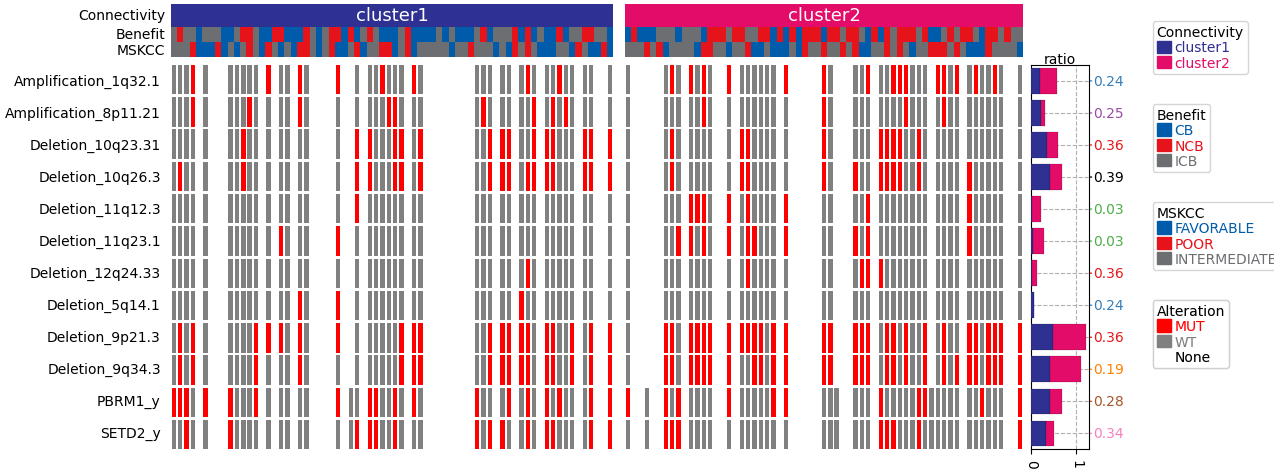

In [13]:
import scienceplots
plt.rc('font', family='DejaVu Sans')
cols=['WT','MUT',"None"]

# calculate genes (row) mutation frequencies.
#row_vc=data.groupby('Genes').apply(lambda x:x.loc[:,cols].sum())
# calculate samples (cols) mutation frequencies.
#col_vc=data.groupby('SampleID').apply(lambda x:x.loc[:,cols].sum())

#Samples with variants at KRAS
#df_col_split=pdf["cres"].copy().replace(1,"cluster1").replace(2,"cluster2").replace(3,"cluster3").replace(4,"cluster4").to_frame()

top_annotation=HeatmapAnnotation(axis=1,
                                Connectivity=anno_simple(df_col_split.cres,colors={"cluster1":"#2e3092","cluster2":"#e40c69"},add_text=True,height=6),
                                Benefit=anno_simple(pdf["Benefit"].to_frame().Benefit,colors={"CB":"#005baa","NCB":"#E7131A","ICB":"#6d6e71"},height=4),
                                MSKCC=anno_simple(pdf["MSKCC"].to_frame(),colors={"FAVORABLE":"#005baa","POOR":"#E7131A","INTERMEDIATE":"#6d6e71"},height=4),
                                verbose=0, label_side='left', label_kws={'horizontalalignment': 'right','visible':True})

#{"ICB":"#6d6e71","NCB":"#E7131A","CB":"#005baa"}
right_annotation = HeatmapAnnotation(axis=0,orientation='right',
                                ratio=anno_barplot(df_p[["c1_ratio","c2_ratio"]],#"c3_ratio","c4_ratio"]],
                                                 colors=["#2e3092","#e40c69"],legend=True,height=15,linewidth=0.1), #,"Purple","Red"
                                label=anno_label(df_p["label"].to_frame(),height=1,relpos=(0,0.5)),
                                verbose=0, label_side='top', label_kws={'horizontalalignment': 'center','rotation':0,'visible':True})

plt.figure(figsize=(12,6))
op=oncoPrintPlotter(data=data_complex,y='Genes',x='SampleID',
                    values=['MUT','WT','None'],colors=["red","grey","white"],subplot_gap=2,label='Alteration',
                    top_annotation=top_annotation,right_annotation=right_annotation,
                    col_split=df_col_split.cres,col_split_order=['cluster1','cluster2'],col_split_gap=3,
                    legend_vpad=4,legend_hpad=4,show_rownames=True,show_colnames=False) #xticklabels_kws={'labelsize':3}

plt.savefig(f"f3.oncoPrint_{cate}{ano}tif",dpi=600,bbox_inches='tight')
plt.savefig(f"f3.oncoPrint_{cate}{ano}svg",dpi=600,bbox_inches='tight')
plt.show()



cols=['AMP','HOMDEL','MUT']
colors=["red","blue","#008000"]
row_vc=data.groupby('Genes').apply(lambda x:x.loc[:,cols].sum())
col_vc=data.groupby('SampleID').apply(lambda x:x.loc[:,cols].sum())
row_var_freq=data.assign(IsVar=(data.loc[:,cols].sum(axis=1)>0)).groupby('Genes').IsVar.sum() * 100 / data.SampleID.nunique()

top_annotation=HeatmapAnnotation(axis=1,orientation='up',
                                Col=anno_barplot(col_vc,colors=colors,legend=False,height=15,linewidth=0.1),
                                verbose=0, label_side='left', label_kws={'horizontalalignment': 'right','visible':False})

right_annotation = HeatmapAnnotation(axis=0,orientation='right',
                                Row=anno_barplot(row_vc,colors=colors,legend=False,height=15,linewidth=0.1),
                                label=anno_label(row_var_freq.apply(lambda x:str(round(x,1))+" %"),
                                                 height=1,relpos=(0,0.5)),
                                verbose=0, label_side='top',
                                label_kws={'horizontalalignment': 'left','rotation':45,'visible':False})

plt.figure(figsize=(12,8))
op=oncoPrintPlotter(data=data,y='Genes',x='SampleID',
                    values=cols,colors=colors,subplot_gap=3,label='Alteration',
                    top_annotation=top_annotation,right_annotation=right_annotation,
                   show_rownames=True,show_colnames=False,width=0.9)

# remove the grid
op.top_annotation.annotations[0].ax.grid(False)
#remove spines for top annotation and right annotation
despine(ax=op.top_annotation.annotations[0].ax,left=False, bottom=True, right=False, top=True)
despine(ax=op.right_annotation.annotations[0].ax,left=True, bottom=False, right=True, top=False)

plt.savefig(f"oncoPrint{cate}{ano}.pdf",bbox_inches='tight')
plt.show()

